# Cognitive, behavioral and social data
**Author**: Mattia Brocco

MERGE OF DATASETS FOR **R_NEO_PI**
```python
a = pd.read_excel(data_dir + "\\R_NEO_PI_Faked.xlsx")
b = pd.read_excel(data_dir + "\\R_NEO_PI_Honest.xlsx")

a.columns = [" ".join([pd.Series(a.columns).apply(lambda s: np.nan if "Unnamed"
                                                  in s else s).fillna(method = "ffill").tolist()[i],
                       a.loc[0][i]]) for i in range(len(a.columns))]
b.columns = [" ".join([pd.Series(b.columns).apply(lambda s: np.nan if "Unnamed"
                                                  in s else s).fillna(method = "ffill").tolist()[i],
                       b.loc[0][i]]) for i in range(len(b.columns))]

a = a.drop(0).reset_index(drop = True)
b = b.drop(0).reset_index(drop = True)

a["CONDITION"] = "FAKE"
b["CONDITION"] = "HONEST"

pd.concat([a, b], ignore_index = True).to_excel(data_dir + "\\R_NEO_PI.xlsx", index = False)
```

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import support
import evaluation
from engine import Classification

%load_ext autoreload
%autoreload 2

data_dir = ".\\data"

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 500

### Datasets at hand

In [2]:
data_descr = pd.DataFrame(dict(zip([f for f in os.listdir(data_dir) if "parquet" in f],
                                   [pd.read_parquet(f"{data_dir}\\{f}").shape for f in os.listdir(data_dir)
                                    if "parquet" in f]))).T.reset_index()
data_descr = data_descr.rename(columns = {"index": "Data", 0: "Sample size",
                                          1: "Features"})
data_descr

,Data,Sample size,Features
0,BF_df_CTU.parquet,442,11
1,BF_df_OU.parquet,460,11
2,BF_df_V.parquet,486,11
3,DT_df_CC.parquet,482,28
4,DT_df_JI.parquet,864,28
5,IADQ_df.parquet,450,10
6,IESR_df.parquet,358,23
7,NAQ_R_df.parquet,712,23
8,PCL5_df.parquet,402,21
9,PHQ9_GAD7_df.parquet,1118,17


## Design a pipeline
***

The goal is to find a stable subset of features across datasets that performs roughly the same across different classifiers. Accoringly, we can define a "good" feature selection procedure, one that does not depend on a specific model, but that allows models to perform roughly the same, and for all the datasets within the scope.

##### DESCRIPTION
1. A given dataset is split in training and test. For every feature, the mean and the standard deviation are computed in order to scale that feauture: $Z=\frac{X-\mu}{\sigma}$. Scaling on the test set is carried out using the same values computed for training data.
2. The actual phase of the selection of a subset of features occurs through a 3-step process:  
    * Train a Decision Tree and apply minimal cost-complexity pruning. <sup>[1]</sup>  
    * Train a Random Forest that expolits gradient boosting <sup>[2]</sup>, in which each tree retains the cost-complexity parameter obtained in the previous step.  
    * Compute permutation importance on this Random Forest <sup>[3]</sup>.  
    * Perform a one-sample test on the mean, given the distribution obtained for each feature importance (with confidence level at 99.999%). This way only features whose importance is significantly greater than zero are retained, all the others are discarded. We call this subset of feature $A^*$  
    * Perform a Wilks test <sup>[4]</sup> comparing two logistic regressions, one fitted with the full set of features, the other with $A^*$. By accepting the null hypothesis of the test (at 95% confidence level), the assertion "the ration  between the likelihoods of the two (nested) models is one".  
    * Train an arbitrary amount of different models in order to assess the quality of the feature selection procedure. If all models show very close accuracy, then the procedure proves to provide a model-indifferent subset $A^*$ of features.


##### SOURCES
* [How can I get statistics to compare nested models in a logistic regression in SPSS?](https://www.ibm.com/support/pages/how-can-i-get-statistics-compare-nested-models-logistic-regression-spss)
* [Likelihood-ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test)

##### SUPPORTING PAPERS
[1] L. Breiman, J. Friedman, R. Olshen, and C. Stone. *Classification and Regression Trees*. Wadsworth, Belmont, CA, 1984.  
[2] J. Friedman, Greedy Function Approximation: *A Gradient Boosting Machine*, The Annals of Statistics, Vol. 29, No. 5, 2001  
[3] Leo Breiman. Random forests. *Machine learning*, 45(1):5-32, 2001.  
[4] Li, Bing; Babu, G. Jogesh (2019). *A Graduate Course on Statistical Inference*. Springer. p. 331

In [34]:
### PIPELINE
# Organize datasets
data_collection = {}
for dataset in [f for f in os.listdir(data_dir) if "parquet" in f]:
    print(dataset.split(".")[0])
    X_tr, X_ts, y_tr, y_ts = Classification().prepare_data(f"{data_dir}\\{dataset}", "CONDITION")
    var_sel = Classification().variable_selection(X_tr, X_ts, y_tr, y_ts)
    perfs, stability = Classification().benchmark_models(X_tr, X_ts, y_tr, y_ts, var_sel)
    data_collection[dataset.split(".")[0]] = [X_tr, X_ts, y_tr, y_ts, var_sel, perfs, stability]
    print(var_sel)
    print(perfs)
    print()
    print("==> STABILITY SCORE: {}".format(stability))
    print("-" * 100)
    print("-" * 100)
    print("-" * 100)
    print()

BF_df_CTU


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 309
Selected 4 features out of 10
{'Features': [2, 4, 6, 7], 'Wilks test p-value': 0.9893064, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.774436   NaN   NaN   NaN   NaN
Logistic Regression  0.812030   6.0   2.0   4.0   7.0
SVC                  0.842105   6.0   2.0   4.0   7.0
Random Forest        0.827068   6.0   7.0   2.0   4.0
Neural Network       0.827068   4.0   6.0   7.0   2.0

==> STABILITY SCORE: 0.417
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

BF_df_OU


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 322
Selected 3 features out of 10
{'Features': [4, 6, 7], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3
Full Logit           0.833333   NaN   NaN   NaN
Logistic Regression  0.811594   6.0   4.0   7.0
SVC                  0.818841   6.0   4.0   7.0
Random Forest        0.782609   6.0   4.0   7.0
Neural Network       0.818841   6.0   7.0   4.0

==> STABILITY SCORE: 0.778
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

BF_df_V


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 340
Selected 1 features out of 10
{'Features': [7], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1
Full Logit           0.760274   NaN
Logistic Regression  0.684932   7.0
SVC                  0.684932   7.0
Random Forest        0.684932   7.0
Neural Network       0.684932   7.0

==> STABILITY SCORE: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

DT_df_CC


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 989us/step
Train size: 337
Selected 3 features out of 27
{'Features': [9, 10, 13], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3
Full Logit           0.682759   NaN   NaN   NaN
Logistic Regression  0.731034  13.0  10.0   9.0
SVC                  0.724138  13.0  10.0   9.0
Random Forest        0.710345  13.0  10.0   9.0
Neural Network       0.731034  13.0   9.0  10.0

==> STABILITY SCORE: 0.778
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

DT_df_JI


  0%|          | 0/100 [00:00<?, ?it/s]

9/9 [==============================] - 0s 1ms/step
Train size: 604
Selected 5 features out of 27
{'Features': [2, 3, 6, 15, 18], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.661538   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.653846   2.0  18.0   6.0  15.0   3.0
SVC                  0.630769  15.0  18.0   2.0   6.0   3.0
Random Forest        0.607692  18.0  15.0   6.0   2.0   3.0
Neural Network       0.657692  18.0   6.0   2.0  15.0   3.0

==> STABILITY SCORE: 0.533
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

IADQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step
Train size: 315
Selected 2 features out of 9
{'Features': [4, 6], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2
Full Logit           0.851852   NaN   NaN
Logistic Regression  0.829630   6.0   4.0
SVC                  0.822222   4.0   6.0
Random Forest        0.814815   4.0   6.0
Neural Network       0.822222   4.0   6.0

==> STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

IESR_df


  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 998us/step
Train size: 250
Selected 4 features out of 22
{'Features': [8, 13, 18, 19], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.935185   NaN   NaN   NaN   NaN
Logistic Regression  0.888889   8.0  18.0  19.0  13.0
SVC                  0.925926  13.0   8.0  18.0  19.0
Random Forest        0.907407  18.0  13.0   8.0  19.0
Neural Network       0.916667  13.0  18.0   8.0  19.0

==> STABILITY SCORE: 0.417
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

NAQ_R_df


  0%|          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step
Train size: 498
Selected 1 features out of 22
{'Features': [9], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1
Full Logit           0.953271   NaN
Logistic Regression  0.929907   9.0
SVC                  0.929907   9.0
Random Forest        0.929907   9.0
Neural Network       0.929907   9.0

==> STABILITY SCORE: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PCL5_df


  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 2ms/step
Train size: 281
Selected 2 features out of 20
{'Features': [1, 4], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2
Full Logit           0.809917   NaN   NaN
Logistic Regression  0.826446   4.0   1.0
SVC                  0.826446   1.0   4.0
Random Forest        0.818182   1.0   4.0
Neural Network       0.826446   4.0   1.0

==> STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PHQ9_GAD7_df


  0%|          | 0/100 [00:00<?, ?it/s]

11/11 [==============================] - 0s 1ms/step
Train size: 782
Selected 4 features out of 16
{'Features': [0, 1, 6, 7], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.991071   NaN   NaN   NaN   NaN
Logistic Regression  0.982143   7.0   1.0   6.0   0.0
SVC                  0.982143   7.0   1.0   6.0   0.0
Random Forest        0.973214   7.0   1.0   6.0   0.0
Neural Network       0.979167   7.0   1.0   6.0   0.0

==> STABILITY SCORE: 1.0
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PID5_df


  0%|          | 0/100 [00:00<?, ?it/s]

8/8 [==============================] - 0s 997us/step
Train size: 576
Selected 3 features out of 220
{'Features': [1, 53, 191], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1   FI 2   FI 3
Full Logit           0.959677   NaN    NaN    NaN
Logistic Regression  0.927419   1.0  191.0   53.0
SVC                  0.939516   1.0  191.0   53.0
Random Forest        0.923387   1.0  191.0   53.0
Neural Network       0.931452   1.0   53.0  191.0

==> STABILITY SCORE: 0.778
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PRFQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step
Train size: 474
Selected 4 features out of 18
{'Features': [6, 7, 8, 11], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.936275   NaN   NaN   NaN   NaN
Logistic Regression  0.892157  11.0   6.0   7.0   8.0
SVC                  0.882353   8.0  11.0   6.0   7.0
Random Forest        0.916667   6.0  11.0   7.0   8.0
Neural Network       0.897059  11.0   8.0   7.0   6.0

==> STABILITY SCORE: 0.417
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

PRMQ_df


  0%|          | 0/100 [00:00<?, ?it/s]

14/14 [==============================] - 0s 1ms/step
Train size: 982
Selected 5 features out of 16
{'Features': [1, 4, 7, 12, 14], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.907583   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.890995   1.0  12.0   7.0   4.0  14.0
SVC                  0.912322   1.0   7.0  12.0   4.0  14.0
Random Forest        0.888626   1.0   7.0  12.0   4.0  14.0
Neural Network       0.895735   1.0   7.0  12.0   4.0  14.0

==> STABILITY SCORE: 0.867
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

RAW_DDDT


  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 1ms/step
Train size: 690
Selected 4 features out of 12
{'Features': [0, 1, 9, 10], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4
Full Logit           0.746622   NaN   NaN   NaN   NaN
Logistic Regression  0.746622   1.0  10.0   9.0   0.0
SVC                  0.766892  10.0   1.0   0.0   9.0
Random Forest        0.760135  10.0   1.0   0.0   9.0
Neural Network       0.743243   1.0  10.0   0.0   9.0

==> STABILITY SCORE: 0.667
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

R_NEO_PI


  0%|          | 0/100 [00:00<?, ?it/s]

729/729 [==============================] - 1s 893us/step
Train size: 54380
Selected 19 features out of 30
{'Features': [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 18, 21, 22, 26, 27, 29], 'Wilks test p-value': 1.0, 'High correlation': False}
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.906938   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.907109  21.0  13.0   5.0  29.0  11.0
SVC                  0.915519  21.0  13.0  29.0   5.0  10.0
Random Forest        0.911185  21.0  29.0  13.0   5.0  22.0
Neural Network       0.914189   5.0  21.0  13.0  29.0  14.0

==> STABILITY SCORE: 0.4
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

sPID-5_df


  0%|          | 0/100 [00:00<?, ?it/s]

10/10 [==============================] - 0s 1ms/step
Train size: 726
Selected 7 features out of 25
{'Features': [2, 4, 11, 14, 16, 20, 23], 'Wilks test p-value': 1.0, 'High correlation': True}
                     Accuracy  FI 1  FI 2  FI 3  FI 4  FI 5
Full Logit           0.961538   NaN   NaN   NaN   NaN   NaN
Logistic Regression  0.971154  23.0  14.0  11.0   4.0  16.0
SVC                  0.971154  23.0  14.0  11.0  20.0   2.0
Random Forest        0.958333  23.0  20.0   4.0  14.0  16.0
Neural Network       0.967949  23.0   4.0  11.0  20.0   2.0

==> STABILITY SCORE: 0.6
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



## Assess quality of analysis
***

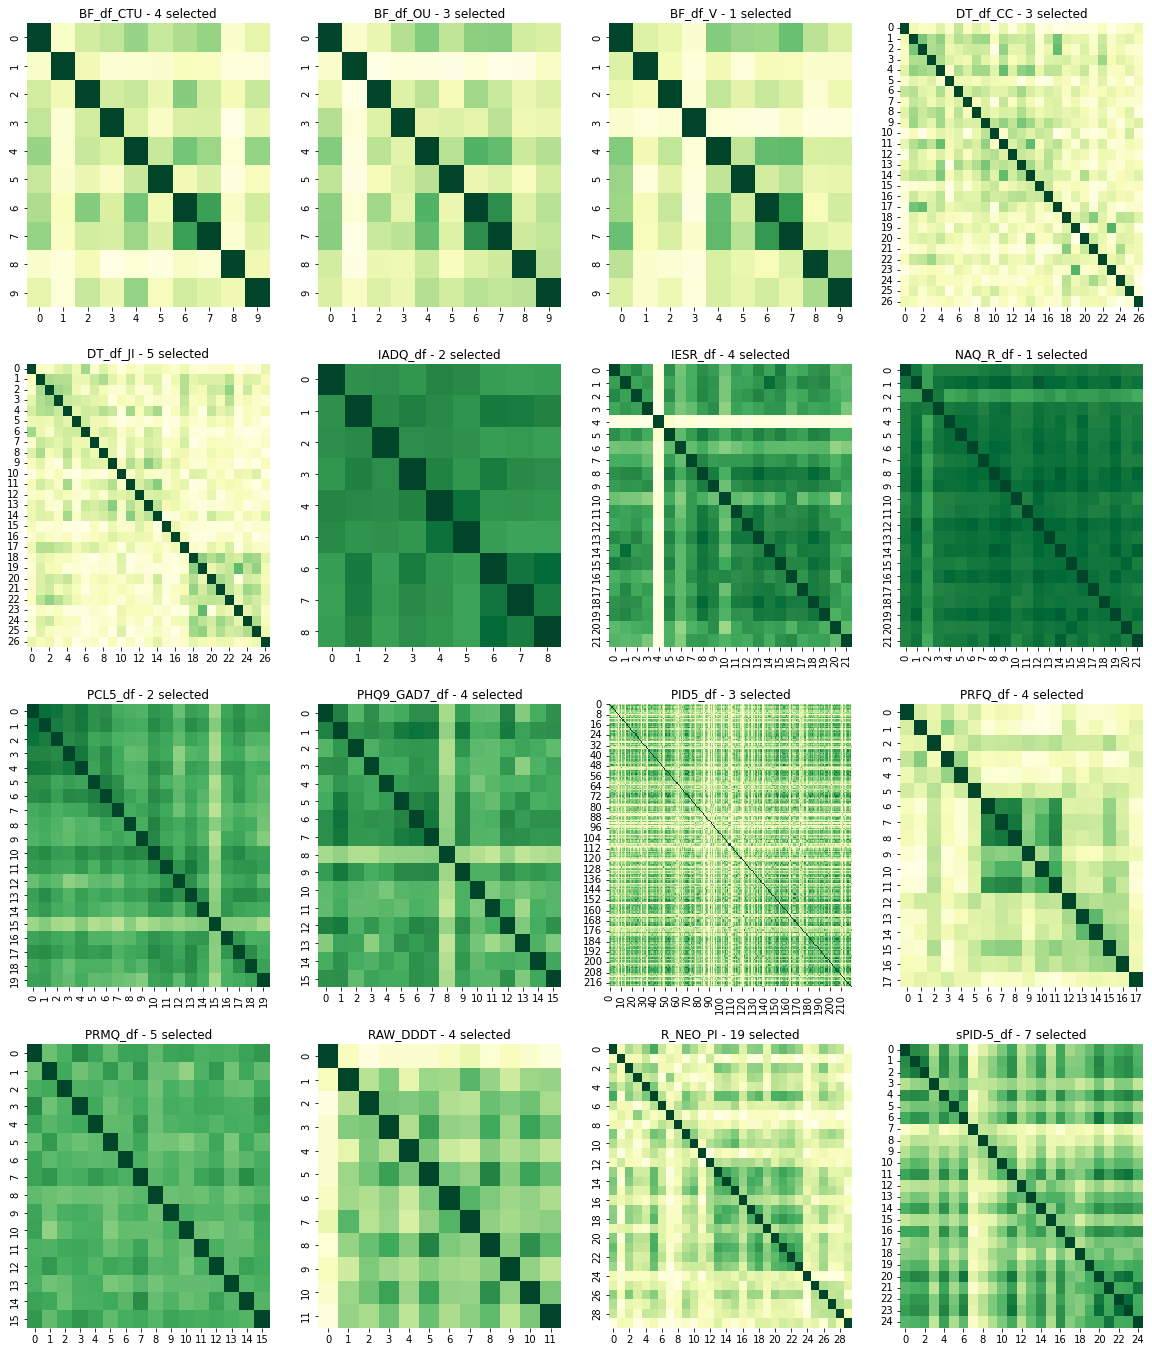

In [35]:
# Compare with correlation matrices
# The greener the higher the correlation
f0, ax0 = plt.subplots(4, 4, figsize = (20, 24))
for n, k in enumerate(data_collection.keys()):
    
    sns.heatmap(pd.DataFrame(data_collection[k][0]).corr().abs(),
                vmin = 0, vmax = 1, cmap = "YlGn",
                cbar = False, ax = ax0[n//4, n%4])
    ax0[n//4, n%4].set_title("{} - {} selected"\
                             .format(k, len(data_collection[k][-3]["Features"])))
plt.show()

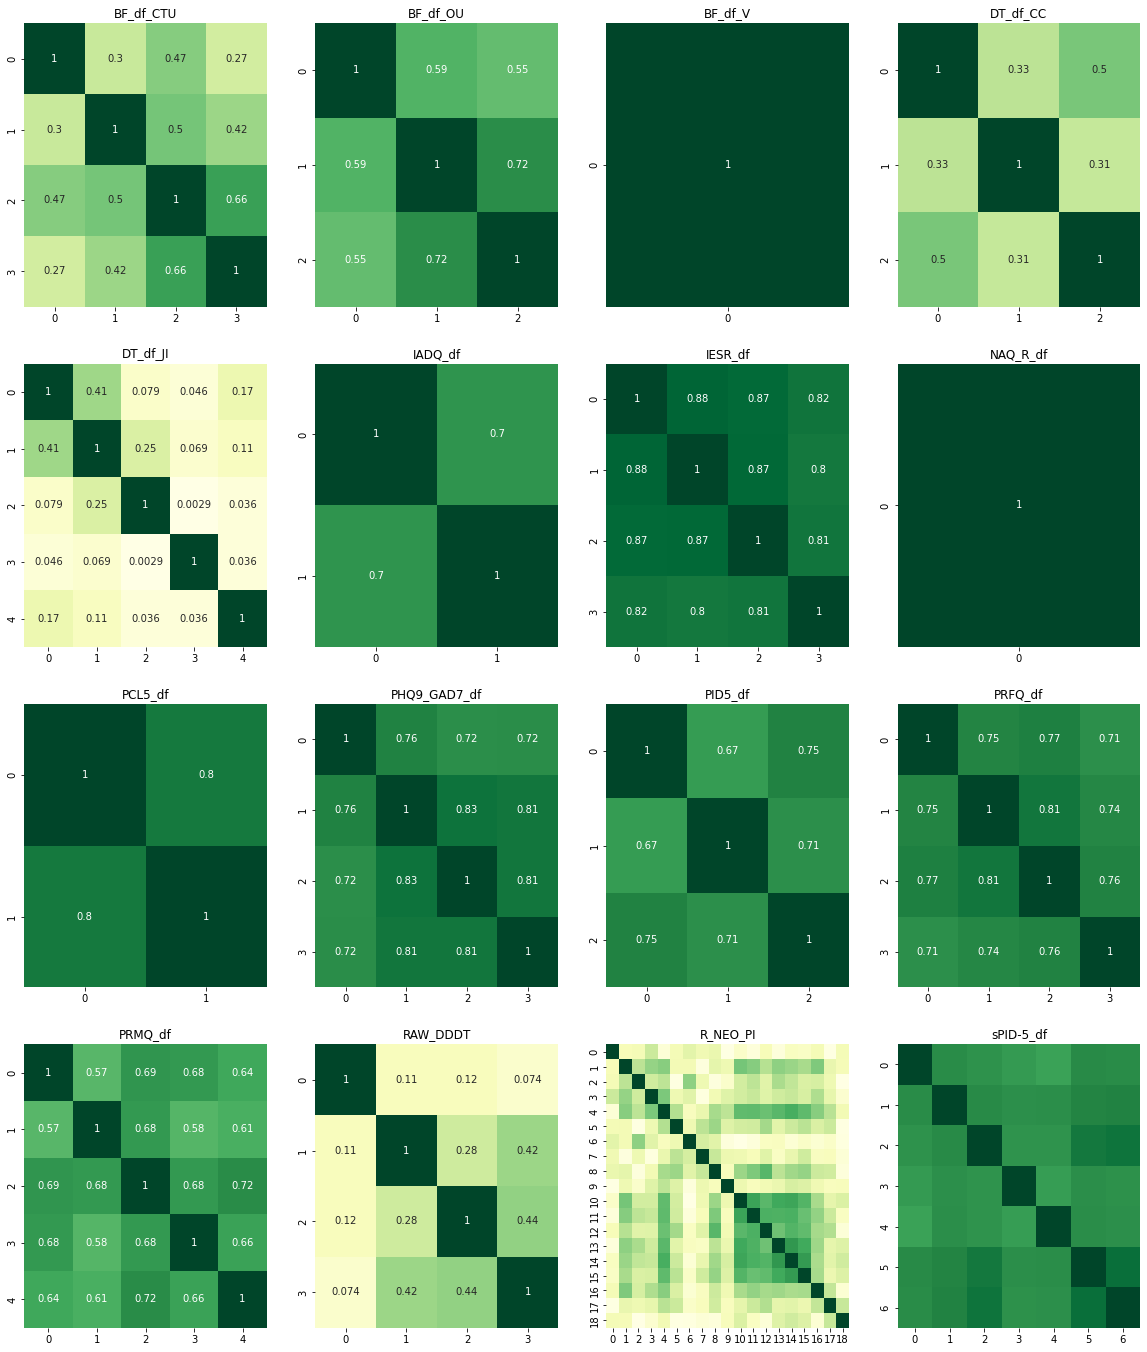

In [37]:
# Correlation matrices of only selected features
# The greener the higher the correlation
f1, ax1 = plt.subplots(4, 4, figsize = (20, 24))
for n, k in enumerate(data_collection.keys()):
    
    feats = data_collection[k][-3]["Features"]
    
    annotation = True if len(feats) < 7 else False
    
    sns.heatmap(pd.DataFrame(data_collection[k][0][:,feats]).corr().abs(),
                vmin = 0, vmax = 1, cmap = "YlGn", annot = annotation,
                cbar = False, ax = ax1[n//4, n%4])

    ax1[n//4, n%4].set_title(k)
    
plt.show()

In [67]:
benchmark = evaluation.lasso_benchmark(data_collection)

benchmark_df = pd.DataFrame(benchmark,
                            columns = ["Dataset", "Algo", "λ min", "λ 1se",
                                       "Zero coeffs at λ min",
                                       "Delta accuracy"]).drop("Algo", axis = 1)

benchmark_df["Delta accuracy"] = benchmark_df["Delta accuracy"].apply(lambda s: s.loc["Accuracy"])
benchmark_df

,Dataset,λ min,λ 1se,Zero coeffs at λ min,Delta accuracy
0,BF_df_CTU,0.100,0.100,0,0.000
1,BF_df_OU,0.100,0.100,0,-0.007
2,BF_df_V,0.100,0.100,0,0.000
3,DT_df_CC,0.100,0.100,0,0.000
4,DT_df_JI,0.768,4.109,0,0.000
5,IADQ_df,0.100,0.100,0,0.000
6,IESR_df,1.436,0.100,0,0.009
7,NAQ_R_df,1.436,0.100,0,0.000
8,PCL5_df,0.100,22.820,0,0.000
9,PHQ9_GAD7_df,25.159,23.154,0,0.000


In [ ]:
#evaluation.graphical_lasso_benchmark(benchmark[7])

## Summarize results
***

In [72]:
data_collection["RAW_DDDT"][5]["Accuracy"].tolist()

[0.7466216216216216,
 0.7466216216216216,
 0.7668918918918919,
 0.7601351351351351,
 0.7432432432432432]

In [73]:
summary = []
for k, v in data_collection.items():
    
    # Dataset name
    # Sample size
    # Training size
    # Initial number of features
    # Selected features
    # Stability
    # ACCURACY: Full Logit
    # ACCURACY: Logistic Regression
    # ACCURACY: SVC
    # ACCURACY: Random Forest
    # ACCURACY: Neural Network
    # Average accuracy (full logit excluded)
    # Accuracy Standard deviation (full logit excluded)
    # Decreased accuracy (mean) w.r.t. full logit
    
    summary += [[k, len(v[2]) + len(v[3]), len(v[2]),
                 v[0].shape[1], len(v[4]["Features"]),
                 v[6], *v[5]["Accuracy"].tolist(),
                 v[5]["Accuracy"][1:].mean(),
                 v[5]["Accuracy"][1:].std(),
                 v[5]["Accuracy"][1:].mean() - v[5]["Accuracy"].tolist()[0]]]
    
summary = pd.DataFrame(summary,
                       columns = ["Dataset name", "Sample size", "Training size", "Number of Features",
                                  "Selected Features", "Feat. Stability", "Accuracy - Logit all features",
                                  "Accuracy - Logit", "Accuracy - SVM", "Accuracy - RF",
                                  "Accuracy - MLP", "Avg Acc. on selected features",
                                  "Accuracy Std on selected features", "Acc. diff. wrt Full logit"])

summary = summary.applymap(lambda v: v if isinstance(v, str) else round(v, 3))

summary.sort_values("Accuracy Std on selected features", ascending = False)

,Dataset name,Sample size,Training size,Number of Features,Selected Features,Feat. Stability,Accuracy - Logit all features,Accuracy - Logit,Accuracy - SVM,Accuracy - RF,Accuracy - MLP,Avg Acc. on selected features,Accuracy Std on selected features,Acc. diff. wrt Full logit
4,DT_df_JI,864,604,27,5,0.533,0.662,0.654,0.631,0.608,0.658,0.637,0.023,-0.024
1,BF_df_OU,460,322,10,3,0.778,0.833,0.812,0.819,0.783,0.819,0.808,0.017,-0.025
6,IESR_df,358,250,22,4,0.417,0.935,0.889,0.926,0.907,0.917,0.910,0.016,-0.025
11,PRFQ_df,678,474,18,4,0.417,0.936,0.892,0.882,0.917,0.897,0.897,0.014,-0.039
0,BF_df_CTU,442,309,10,4,0.417,0.774,0.812,0.842,0.827,0.827,0.827,0.012,0.053
12,PRMQ_df,1404,982,16,5,0.867,0.908,0.891,0.912,0.889,0.896,0.897,0.011,-0.011
13,RAW_DDDT,986,690,12,4,0.667,0.747,0.747,0.767,0.760,0.743,0.754,0.011,0.008
3,DT_df_CC,482,337,27,3,0.778,0.683,0.731,0.724,0.710,0.731,0.724,0.010,0.041
10,PID5_df,824,576,220,3,0.778,0.960,0.927,0.940,0.923,0.931,0.930,0.007,-0.029
5,IADQ_df,450,315,9,2,0.667,0.852,0.830,0.822,0.815,0.822,0.822,0.006,-0.030


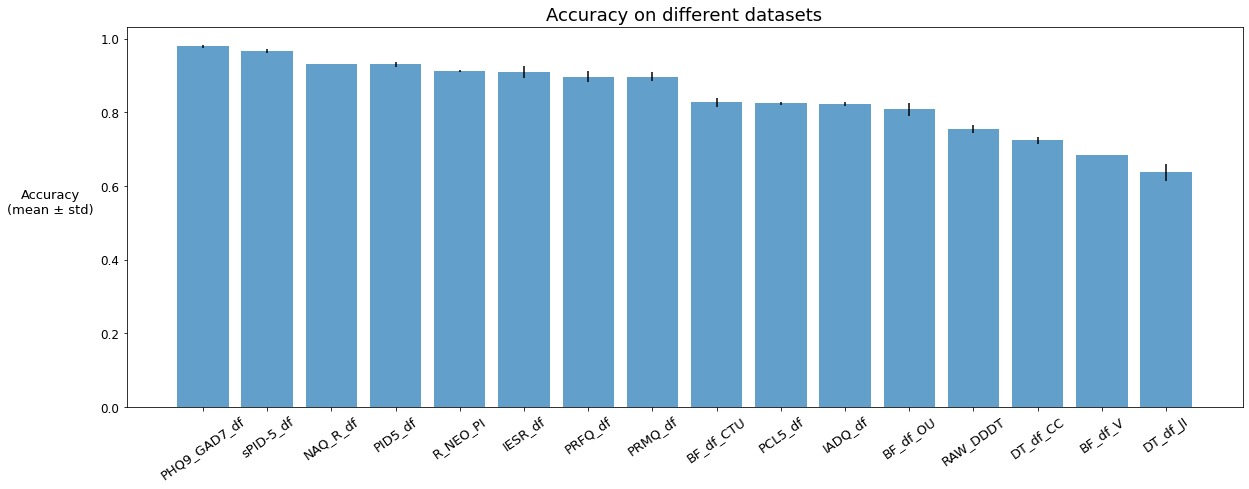

In [74]:
plt.figure(figsize = (20, 7))
plt.bar(x = summary.sort_values("Avg Acc. on selected features",
                                ascending = False)["Dataset name"],
        height = summary.sort_values("Avg Acc. on selected features",
                                     ascending = False)["Avg Acc. on selected features"],
        yerr = summary.sort_values("Avg Acc. on selected features",
                                   ascending = False)["Accuracy Std on selected features"], alpha = .7)
plt.xticks(rotation = 35, fontsize = 13)
plt.yticks(fontsize = 12)
plt.ylabel("Accuracy\n(mean ± std)", fontsize = 13, rotation = 0, labelpad = 50)
plt.title("Accuracy on different datasets", fontsize = 18)
plt.show()

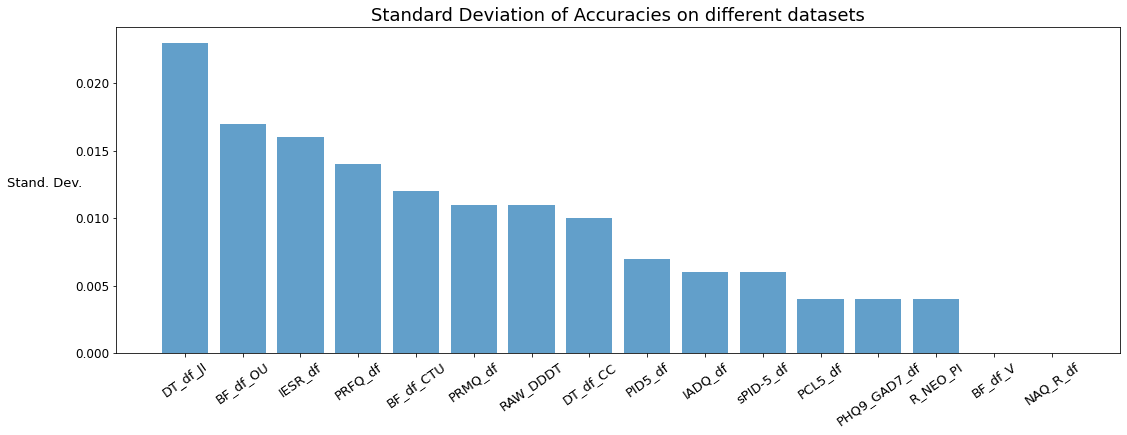

In [75]:
plt.figure(figsize = (18, 6))
plt.bar(x = summary.sort_values("Accuracy Std on selected features",
                                ascending = False)["Dataset name"],
        height = summary.sort_values("Accuracy Std on selected features",
                                     ascending = False)["Accuracy Std on selected features"], alpha = .7)
plt.xticks(rotation = 35, fontsize = 13)
plt.yticks(fontsize = 12)
plt.ylabel("Stand. Dev.", fontsize = 13, rotation = 0, labelpad = 30)
plt.title("Standard Deviation of Accuracies on different datasets", fontsize = 18)
plt.show()

---
---
---